In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings

# Configuration
SEED = 42
WINDOW_SIZE = 12
PREDICT_AHEAD = 1

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
warnings.filterwarnings('ignore')

In [7]:
# Paths
data_path = 'StationFootfall_Merged_2019-2023.csv'
coords_path = 'station_coords.csv'

# Load data
print("Loading data...")
df = pd.read_csv(data_path)

# Create TotalFootfall
df['TotalFootfall'] = df['EntryTapCount'] + df['ExitTapCount']

# Pivot to wide format: Index=TravelDate, Columns=Station, Values=TotalFootfall
ts_data = df.pivot_table(index='TravelDate', columns='Station', values='TotalFootfall', aggfunc='sum')

# Convert index to datetime
ts_data.index = pd.to_datetime(ts_data.index)
ts_data = ts_data.sort_index()

# Load coordinates
station_coords = pd.read_csv(coords_path)
station_coords = station_coords.set_index('Station')
station_coords = station_coords[['latitude', 'longitude']]

# Align stations
common_stations = ts_data.columns.intersection(station_coords.index)
ts_data = ts_data[common_stations]
station_coords = station_coords.loc[common_stations]

# Replace 0 with NaN before resampling to avoid averaging zeros
ts_data = ts_data.replace(0, np.nan)

# Resample to weekly average
print("Resampling to weekly average...")
ts_data = ts_data.resample('W').mean()

print(f"Resampled data shape: {ts_data.shape}")

# Supplement missing values
# Interpolate
ts_data = ts_data.interpolate(method='linear', limit_direction='both')
# Fill remaining NaNs with 0 (if any)
ts_data = ts_data.fillna(0)

print(f"Processed data shape: {ts_data.shape}")

Loading data...
Resampling to weekly average...
Resampled data shape: (261, 436)
Processed data shape: (261, 436)


In [8]:
# Feature Engineering
num_samples_total = len(ts_data) - WINDOW_SIZE - PREDICT_AHEAD + 1
train_samples_count = int(0.7 * num_samples_total)
# The last time step used in training (including target)
train_end_idx = train_samples_count + WINDOW_SIZE + PREDICT_AHEAD - 1

print(f"Fitting scaler on first {train_end_idx} time steps (Training set).")

scaler = StandardScaler()
footfall_cols = ts_data.columns # All columns are footfall now

# Fit on training data only
scaler.fit(ts_data.iloc[:train_end_idx][footfall_cols])

# Transform all data
ts_data[footfall_cols] = scaler.transform(ts_data[footfall_cols])

print("Data normalized (StandardScaler) - Fit on Train, Transformed All.")

def create_dataset(ts_data, window_size, predict_ahead):
    X_list = []
    y_list = []
    
    stations = ts_data.columns
    
    # Iterate through time steps
    num_samples = len(ts_data) - window_size - predict_ahead + 1
    
    for idx in range(num_samples):
        # Extract window for all stations
        # Shape: (window_size, num_stations)
        window_data = ts_data.iloc[idx : idx + window_size]
        
        # Target time step
        target_idx = idx + window_size + predict_ahead - 1
        target_data = ts_data.iloc[target_idx]
        
        # For each station, create a sample
        for station in stations:
            # Lag features: values of this station in the window
            lags = window_data[station].values
            
            # Features: [Lag_1, Lag_2, ..., Lag_12]
            features = lags 
            
            target = target_data[station]
            
            X_list.append(features)
            y_list.append(target)
            
    return np.array(X_list), np.array(y_list)

print("Creating dataset...")
X, y = create_dataset(ts_data, WINDOW_SIZE, PREDICT_AHEAD)
print(f"X shape: {X.shape}, y shape: {y.shape}")

Fitting scaler on first 186 time steps (Training set).
Data normalized (StandardScaler) - Fit on Train, Transformed All.
Creating dataset...
X shape: (108564, 12), y shape: (108564,)


In [9]:
# Split Data into Training, Validation, and Test Sets

# Calculate number of time steps available for training/testing
num_time_steps = len(ts_data) - WINDOW_SIZE - PREDICT_AHEAD + 1
num_stations = len(ts_data.columns)

# Split indices based on time steps
train_steps = int(0.7 * num_time_steps)
val_steps = int(0.15 * num_time_steps)
test_steps = num_time_steps - train_steps - val_steps

print(f"Total time steps: {num_time_steps}")
print(f"Train steps: {train_steps}, Val steps: {val_steps}, Test steps: {test_steps}")

# The X and y arrays are ordered by time, then station.
# So the first (train_steps * num_stations) samples are training data.

train_size = train_steps * num_stations
val_size = val_steps * num_stations
test_size = test_steps * num_stations

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y[train_size + val_size :]

# Reshape y for TabNet (N, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Val shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Total time steps: 249
Train steps: 174, Val steps: 37, Test steps: 38
Train shape: (75864, 12), (75864, 1)
Val shape: (16132, 12), (16132, 1)
Test shape: (16568, 12), (16568, 1)


In [10]:
# Initialize and Train TabNet Model

clf = TabNetRegressor(
    n_d=16, 
    n_a=16, 
    n_steps=3,
    gamma=1.3, 
    n_independent=2, 
    n_shared=2,
    seed=SEED, 
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', # "sparsemax"
    verbose=10
)

print("Training TabNet model...")
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['mse'],
    max_epochs=100,
    patience=10,
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

print("Training complete.")

Training TabNet model...
epoch 0  | loss: 0.21874 | train_mse: 0.1083  | valid_mse: 18522.57883|  0:00:05s
epoch 10 | loss: 0.08454 | train_mse: 0.08221 | valid_mse: 20265.7082|  0:01:00s
epoch 20 | loss: 0.07727 | train_mse: 0.0776  | valid_mse: 9346.76936|  0:01:56s
epoch 30 | loss: 0.07198 | train_mse: 0.07258 | valid_mse: 14500.46597|  0:02:51s

Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_mse = 7251.07365
Training complete.


Evaluated on 38 time steps for 436 stations.
------------------------------
Test MSE: 13009924.2240
Test MAE: 1570.5514
Test RMSE: 3606.9273
Test MAPE: 14.8640%
Test R2 (Avg per Station): -175649868762899587467837440.0000
Test R2 (Filtered, > -100): -0.1414
------------------------------

--- Prediction Results (Sample) ---
   Station_Index        Actual     Predicted     Station_Name
0              0   1631.000000   1526.095957   Abbey Road DLR
1              1  19198.857143  11334.622525       Abbey Wood
2              2   3226.571429   4122.739073    Acton Central
3              3   4798.166667   2126.354171  Acton Main Line
4              4  12011.571429  12637.472913       Acton Town
5              5  14976.714286  16701.328132          Aldgate
6              6  28038.714286  29832.755574     Aldgate East
7              7   2066.857143   1991.549477       All Saints
8              8   6612.000000   6819.458518         Alperton
9              9   3740.857143   3012.236757         A

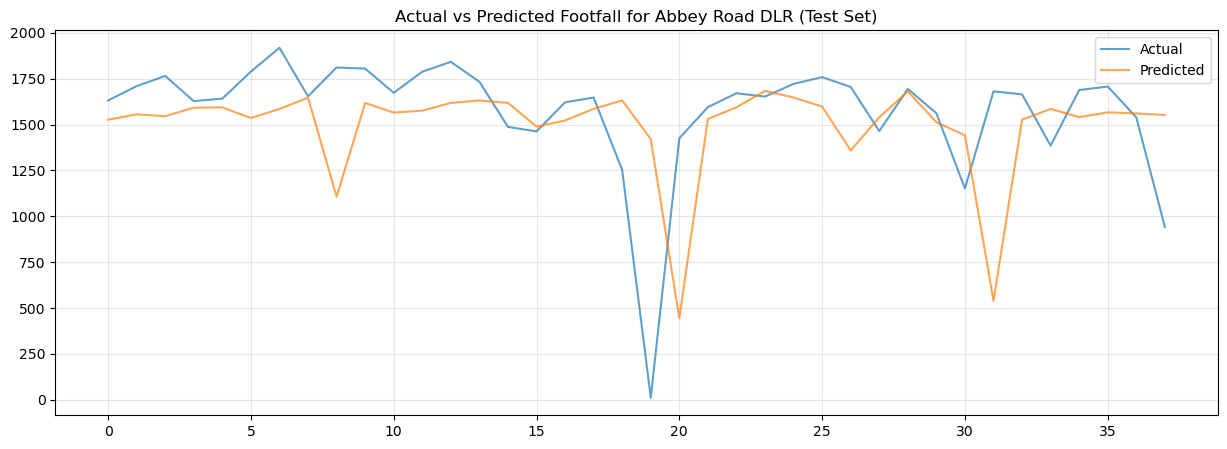

In [ ]:
# Evaluate Model Performance

# Predict on test set
y_pred = clf.predict(X_test)

# Flatten y_pred and y_test for inverse transform logic
y_pred = y_pred.flatten()
y_test_flat = y_test.flatten()

# Get scaler parameters
means = scaler.mean_
scales = scaler.scale_

# Create station indices for the test set
station_indices_test = np.tile(np.arange(num_stations), test_steps)

# Ensure shapes match (handle potential truncation if any)
min_len = min(len(y_test_flat), len(y_pred), len(station_indices_test))
y_test_aligned = y_test_flat[:min_len]
y_pred_aligned = y_pred[:min_len]
station_indices_test = station_indices_test[:min_len]

# Inverse transform (Flattened)
y_test_inv_flat = y_test_aligned * scales[station_indices_test] + means[station_indices_test]
y_pred_inv_flat = y_pred_aligned * scales[station_indices_test] + means[station_indices_test]

complete_steps = min_len // num_stations
truncate_idx = complete_steps * num_stations

y_test_reshaped = y_test_inv_flat[:truncate_idx].reshape(complete_steps, num_stations)
y_pred_reshaped = y_pred_inv_flat[:truncate_idx].reshape(complete_steps, num_stations)

print(f"Evaluated on {complete_steps} time steps for {num_stations} stations.")

# --- Calculate Metrics ---

# 1. Standard Metrics (Average per Station)
mae = mean_absolute_error(y_test_reshaped, y_pred_reshaped)
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reshaped, y_pred_reshaped)

# Calculate MAPE
mask = y_test_reshaped != 0
mape = np.mean(np.abs((y_test_reshaped[mask] - y_pred_reshaped[mask]) / y_test_reshaped[mask])) * 100

print("-" * 30)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape:.4f}%")
print(f"Test R2 (Avg per Station): {r2:.4f}")

# 2. Filtered R2 (Removing extremely poor stations)
r2_per_station = r2_score(y_test_reshaped, y_pred_reshaped, multioutput='raw_values')
valid_stations = np.where(r2_per_station > -100)[0]
r2_filtered = r2_per_station[valid_stations].mean()

print(f"Test R2 (Filtered, > -100): {r2_filtered:.4f}")
print("-" * 30)

# --- Print Prediction Results (Sample) ---
print("\n--- Prediction Results (Sample) ---")
# Flatten again for DataFrame display
results_df = pd.DataFrame({
    'Station_Index': np.tile(np.arange(num_stations), complete_steps),
    'Actual': y_test_reshaped.flatten(),
    'Predicted': y_pred_reshaped.flatten()
})

# Map station index back to station name
stations = ts_data.columns
results_df['Station_Name'] = results_df['Station_Index'].map(lambda x: stations[x])

print(results_df.head(10))

# Plot a sample station
sample_station = stations[0]
station_data = results_df[results_df['Station_Name'] == sample_station]

plt.figure(figsize=(15, 5))
plt.plot(station_data['Actual'].values, label='Actual', alpha=0.7)
plt.plot(station_data['Predicted'].values, label='Predicted', alpha=0.7)
plt.title(f"Actual vs Predicted Footfall for {sample_station} (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()